In [1]:
from google.colab import drive

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
os.chdir('drive/My Drive/Colab/AIFinal/')
!ls

data  example.ipynb  FinalProject.ipynb  label	T2.ipynb  training  unet-master


In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
im_width = 128
im_height = 128
border = 5
path_data = './training/img/'
path_label = './training/label/'

In [67]:
# Get and resize train images and masks

x = np.zeros((463, im_height, im_width, 1), dtype=np.float32)
y = np.zeros((463, im_height, im_width, 1), dtype=np.float32)

index = 0
for fname in os.listdir(path_data):
    img = load_img(path_data + fname, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

    img = load_img(path_label + fname, grayscale=True)
    y_img = img_to_array(img)
    y_img = resize(y_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    
    # Save images
    x[index, ..., 0] = x_img.squeeze() / 255
    y[index] = y_img / 255
    
    index += 1




/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
y

In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.15, random_state=2018)

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


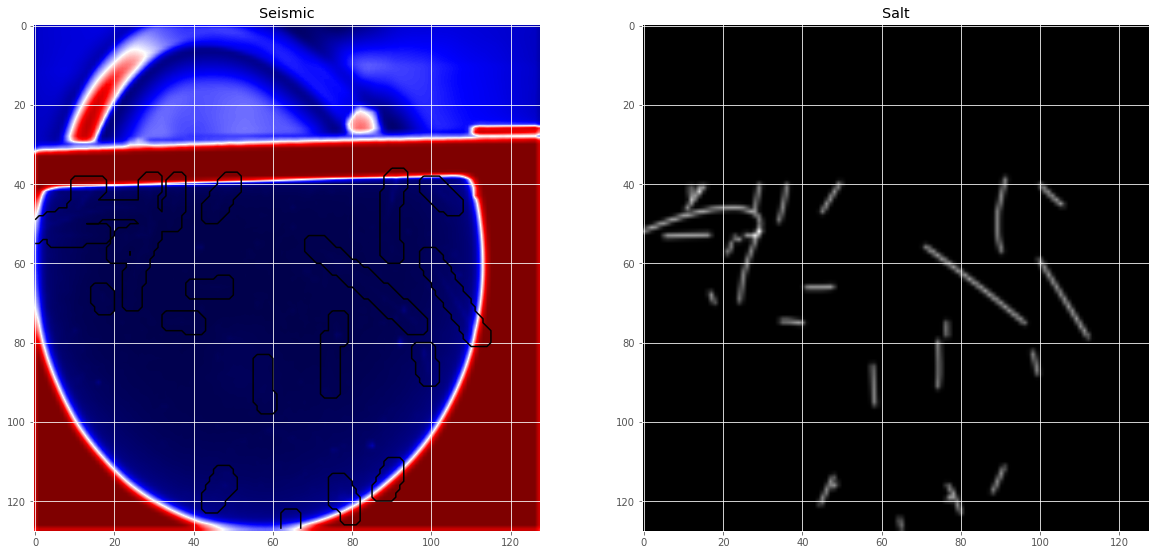

In [78]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
# model.summary()

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [142]:
results = model.fit(x, y, batch_size=32, epochs=100, callbacks=callbacks, validation_split=0.3)
#                     validation_data=(X_valid, y_valid))

Train on 324 samples, validate on 139 samples
Epoch 1/100
324/324 [==============================] - 17s 53ms/step - loss: 0.4291 - acc: 0.7599 - val_loss: 0.2915 - val_acc: 0.6858

Epoch 00001: val_loss improved from inf to 0.29155, saving model to model-tgs-salt.h5
Epoch 2/100
324/324 [==============================] - 3s 10ms/step - loss: 0.3140 - acc: 0.8174 - val_loss: 0.2195 - val_acc: 0.7230

Epoch 00002: val_loss improved from 0.29155 to 0.21950, saving model to model-tgs-salt.h5
Epoch 3/100
324/324 [==============================] - 3s 9ms/step - loss: 0.2641 - acc: 0.8187 - val_loss: 0.2127 - val_acc: 0.7257

Epoch 00003: val_loss improved from 0.21950 to 0.21273, saving model to model-tgs-salt.h5
Epoch 4/100
324/324 [==============================] - 3s 9ms/step - loss: 0.2315 - acc: 0.8187 - val_loss: 0.2131 - val_acc: 0.7266

Epoch 00004: val_loss did not improve from 0.21273
Epoch 5/100
324/324 [==============================] - 3s 9ms/step - loss: 0.2031 - acc: 0.8187 - 

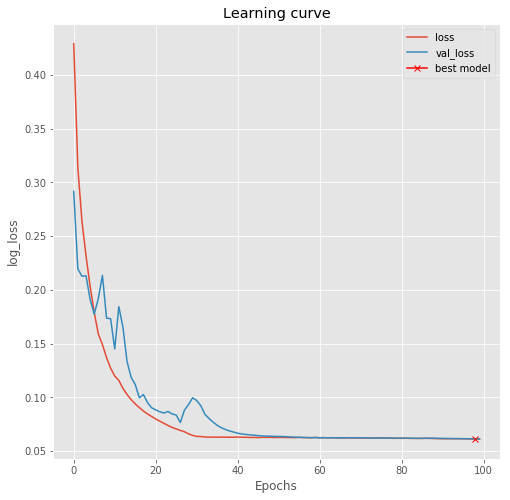

In [143]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
# Load best model
model.load_weights('model-tgs-salt.h5')

In [145]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)


70/70 [==============================] - 0s 3ms/step


[0.06151458929691996, 0.781382531779153]

In [146]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

70/70 [==============================] - 0s 2ms/step


In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0],cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Phone')

    ax[1].imshow(y[ix].squeeze(),cmap='bwr')
    ax[1].set_title('Scratch')

    ax[2].imshow(softmax(preds[ix].squeeze())*255)#, vmin=0, vmax=1,cmap='bwr')
    if has_mask:
        ax[2].contour(preds[ix].squeeze(), colors='k', levels=[0.2])
    ax[2].set_title('Scratch Predicted')
    
#     ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1,cmap='bwr')
#     if has_mask:
#         ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.3])
#     ax[3].set_title('Scratch Predicted binary');

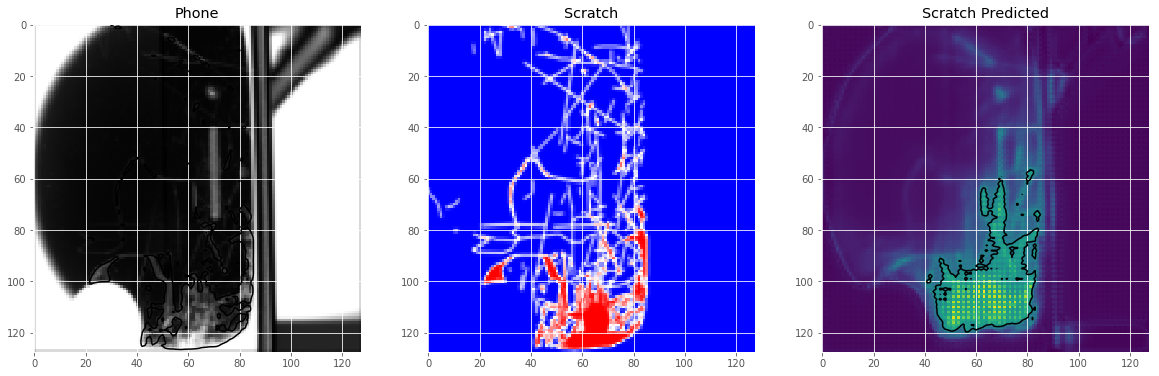

In [343]:
# Check if training data looks all right
# plot_sample(X_train, y_train, preds_train, preds_train_t, ix=250)

plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=22)

In [183]:
preds_val[25].max()

0.09538877

In [0]:
import scipy
def softmax(x):
    return scipy.special.softmax(x)

In [333]:
white_sum = 0
white_overlap = 0
IoU = 0

i = 47
for j in range(128):
    for k in range(128):
        if y_valid[i, j, k, 0]*255 >= 10 or preds_val[i, j, k, 0]*255 > 10:
            white_sum += 1
        if y_valid[i, j, k, 0]*255 >= 10 and preds_val[i, j, k, 0]*255 > 10:
            white_overlap += 1
IoU += white_overlap / white_sum
    
        
               
IoU


0.23773209549071617

In [299]:
# np.unique(preds_val[5].squeeze()*255)
index

0

In [306]:
temp[0,0]

array([6.0858285e-05], dtype=float32)